In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36479")
client

<Client: 'tcp://127.0.0.1:36479' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
from MITgcmutils import rdmds
from xmitgcm import open_mdsdataset
import os.path as op
import os
from scipy.interpolate import griddata, interp1d
# from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
ddir = '/tank/chaocean/qjamet/'
# dir_grd50 = '/tank/spectre/gridMIT_50/'
# dir_obcs50 = '/tank/spectre/tuchida/obcs_50/'
dir_grd50 = '/tank/spectre/gridMIT_50/smooth_topo/'
dir_obcs50 = '/tank/spectre/tuchida/SPECTRE/obcs_50/smooth_topo/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'

In [5]:
#-- some parameters --
nt = 73         #also need earlier and past year for interpolation, 
                #for now it is coded in a 'normal year' fashion
# nproc = 36      #number of processors used for parallelization 

#-- time param for loading --
dt = 200                #1/12 model time step
spy = 86400*365
dump = 5*86400       #5-d dumps
d_iter = dump/dt
nDump = spy/dump;

rSphere = 6370000.0

In [6]:
#-----------------------------------------------------
# Define horizontal and vertical interpolation methods 
#-----------------------------------------------------

def interp_obcs(tttt):
  #print("-- tt=%02i || Interpolate %s at bdy %s --" % (tttt, varN[ivar], bbdy[ibdy]))
    tmpvarin = var12[tttt, :, :, :].reshape([nr12, ny2*nx2])
  #- hz interp -
    tmpvar = np.zeros([nr12+2, nxy50])
    for kkk in range(nr12):
        tmpvar[kkk+1] = griddata(xy12, tmpvarin[kkk, :], (xx50, yy50), method=mmeth)
    tmpvar[0, :] = tmpvar[1, :]
    tmpvar[-1, :] = tmpvar[-2, :]
  #- vert interp -
    tmpvar2 = np.zeros([nr50, nxy50])
    for ij in range(nxy50):
    # FOR TRACER ONLY
    # find last wet point and repeat it downward for constant interpolation 
        if varN[ivar] == 't' or varN[ivar] == 's':
            tmpk = np.where( tmpvar[:, ij] == 0.0 )[0]
            if tmpk.size > 0:
                if (tmpk[0] > 0 and tmpk[0] < (nr12+1) ):
                    tmpvar[tmpk[0]:, ij] = tmpvar[tmpk[0]-1, ij]
    #
        f = interp1d(zzz12, tmpvar[:, ij], fill_value='extrapolate')
        tmpvar2[:, ij] = f(rC50)
    return tmpvar2

In [7]:
iper = 2007
offset = int((iper-1958)*spy/dt)
# iters = np.arange(d_iter, (nDump+1)*d_iter, d_iter, dtype='int') + offset
iters = (np.arange(d_iter, (nDump+1)*d_iter, d_iter, dtype='int') + offset)
print(iters)
tmpdir = str('%s%04i' % (dir_obcs50, iper))
print(tmpdir)
if not op.isdir(tmpdir):
    os.makedirs( tmpdir )

[7728480 7730640 7732800 7734960 7737120 7739280 7741440 7743600 7745760
 7747920 7750080 7752240 7754400 7756560 7758720 7760880 7763040 7765200
 7767360 7769520 7771680 7773840 7776000 7778160 7780320 7782480 7784640
 7786800 7788960 7791120 7793280 7795440 7797600 7799760 7801920 7804080
 7806240 7808400 7810560 7812720 7814880 7817040 7819200 7821360 7823520
 7825680 7827840 7830000 7832160 7834320 7836480 7838640 7840800 7842960
 7845120 7847280 7849440 7851600 7853760 7855920 7858080 7860240 7862400
 7864560 7866720 7868880 7871040 7873200 7875360 7877520 7879680 7881840
 7884000]
/tank/spectre/tuchida/SPECTRE/obcs_50/smooth_topo/2007


In [8]:
md = 0
dsg = open_mdsdataset(op.join('/tank/spectre/RUNS/','%04d/memb%03d/00' 
                              % (2003,md)), 
                      grid_dir='/tank/spectre/RUNS/grid/',
                      prefix=[], 
                      delta_t=dt , iters=iters[0]                              
                     )
dsg

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 1, XC: 2052, YC: 1000, XG: 2052, YG: 1000, Z: 75, Zp1: 76,
              Zu: 75, Zl: 75)
Coordinates: (12/33)
    iter     (time) int64 8B 7728480
  * time     (time) timedelta64[ns] 8B 17890 days
  * XC       (XC) >f4 8kB 278.4 278.4 278.5 278.5 ... 319.4 319.4 319.4 319.4
  * YC       (YC) >f4 4kB 25.51 25.53 25.55 25.57 ... 45.43 45.45 45.47 45.49
  * XG       (XG) >f4 8kB 278.4 278.4 278.4 278.5 ... 319.4 319.4 319.4 319.4
  * YG       (YG) >f4 4kB 25.5 25.52 25.54 25.56 ... 45.42 45.44 45.46 45.48
    ...       ...
    maskW    (Z, YC, XG) bool 154MB dask.array<chunksize=(75, 1000, 2052), meta=np.ndarray>
    maskS    (Z, YG, XC) bool 154MB dask.array<chunksize=(75, 1000, 2052), meta=np.ndarray>
    maskInC  (YC, XC) bool 2MB dask.array<chunksize=(1000, 2052), meta=np.ndarray>
    maskInS  (YG, XC) bool 2MB dask.array<chunksize=(1000, 2052), meta=np.ndarray>
    maskInW  (YC, XG) bool 2MB dask.array<chunksize=(1000, 2052), meta=np.ndarray>
    rhoRef   (Z) >f4 300B 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.045e+03
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(data_dir='/tank/spectre...

In [9]:
nmembs = np.concatenate((np.arange(15,24),np.arange(36,60)))

for nmemb in nmembs:
    ds12 = open_mdsdataset(op.join(ddir,'RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                   % (nmemb,iper)), 
                           grid_dir=gdir,
                           iters=iters[0],
                           prefix=['diag_ocnTave'], delta_t=2e2,
                          )
    
    rC12 = ds12.Z
    rF12 = ds12.Zl
    [nr12] = rC12[:].shape
    xx12 = rdmds(gdir + 'XC')
    [ny12, nx12]  = xx12.shape
    zzz12 = np.zeros([nr12+2])
    zzz12[1:-1] = rC12[:]
    zzz12[-1] = rF12[-1]
    #- 1/50 -
    rC50 = rdmds(dir_grd50 + 'RC')[:, 0, 0]
    [nr50] = rC50.shape
    xx50 = rdmds(dir_grd50 + 'XC')
    [ny50, nx50]  = xx50.shape

    #-- variables and boundaries --
    varN = ['t', 's', 'uE', 'vN']
    nvar = len(varN)
    varOrder = [0, 1, 2, 3]         #Ordering of variables in diagnostic used to make obcs
    varName = ['THETA','SALT' ,'UVEL' ,'VVEL']
    bbdy = ['south', 'north', 'east', 'west']
    nnbdy = len(bbdy)
    
    #------------------------------------------------------------------
    #       Make Boundary conditions from our previous 1/12 runs
    #------------------------------------------------------------------

    #-- Loop over variables and boundaries --
    for ivar in range(nvar):
        if varN[ivar] == 'uE':
            flag_repz = False   #to repeat grid points downward for vert. interp
            mmeth = 'cubic'     #interpolation method
        # 1/50
            x50deg = rdmds(dir_grd50 + 'XG')
            y50deg = rdmds(dir_grd50 + 'YC')
            hFac50 = rdmds(dir_grd50 + 'hFacW')
        # 1/12
            x12deg = rdmds(gdir + 'XG')
            y12deg = rdmds(gdir + 'YC')
        elif varN[ivar] == 'vN':
            flag_repz = False   #to repeat grid points downward for vert. interp
            mmeth = 'cubic'     #interpolation method
        # 1/50
            x50deg = rdmds(dir_grd50 + 'XC')
            y50deg = rdmds(dir_grd50 + 'YG')
            hFac50 = rdmds(dir_grd50 + 'hFacS')
        # 1/12
            x12deg = rdmds(gdir + 'XC')
            y12deg = rdmds(gdir + 'YG')
        else:         # tracers
            flag_repz = True    #to repeat grid points downward for vert. interp
            mmeth = 'linear'    #interpolation method
        # 1/50
            x50deg = rdmds(dir_grd50 + 'XC')
            y50deg = rdmds(dir_grd50 + 'YC')
            hFac50 = rdmds(dir_grd50 + 'hFacC')
        # 1/12
            x12deg = rdmds(gdir + 'XC')
            y12deg = rdmds(gdir + 'YC')
        # plt.imshow(hFac50[20*ivar])
        # plt.show()
      # define associated grid in [m] with co-localized origin
        tmpx50 = np.radians(x50deg - x50deg[0,0]) * rSphere * np.cos(np.radians(y50deg))
        tmpy50 = np.radians(y50deg - y50deg[0,0]) * rSphere
        tmpx12 = np.radians(x12deg - x50deg[0,0]) * rSphere * np.cos(np.radians(y12deg))
        tmpy12 = np.radians(y12deg - y50deg[0,0]) * rSphere
      # need to be consistent with ordering in bbdy
        [sbdy, nbdy, wbdy, ebdy] = [y50deg.min(), y50deg.max(), x50deg.min(), x50deg.max()]
      #
        for ibdy in range(nnbdy):
            print("== Deal with %s at bdy %s ==" % (varN[ivar], bbdy[ibdy]) )
            #
            #-- boundary parameters --
            deltaxy = 3 #+/- deltaxy grid points (on the 1/12 grid) around boundary
            if bbdy[ibdy] == 'south':
          #- 1/50 -
                if varN[ivar] == 'vN': #obcs are applied at inner grid points
                    msk50 = hFac50[:, 1, :]
                    xx50 = tmpx50[1, :]
                    yy50 = tmpy50[1, :]
                else:
                    msk50 = hFac50[:, 0, :]
                    xx50 = tmpx50[0, :]
                    yy50 = tmpy50[0, :]
                nxy50 = nx50
          #-  associated subdomain on the 1/12 grid -
                iiw = np.where(x12deg[0,:]>wbdy)[0][0] - deltaxy
                iie = np.where(x12deg[0,:]>ebdy)[0][0] + deltaxy
                jjs = np.where(y12deg[:,0]>sbdy)[0][0] - deltaxy
                jjn = np.where(y12deg[:,0]>sbdy)[0][0] + deltaxy
            elif bbdy[ibdy] == 'north':
          #- 1/50 -
                msk50 = hFac50[:, -1, :]
                xx50 = tmpx50[-1, :]
                yy50 = tmpy50[-1, :]
                nxy50 = nx50
          #-  associated subdomain on the 1/12 grid -
                iiw = np.where(x12deg[0,:]>wbdy)[0][0] - deltaxy
                iie = np.where(x12deg[0,:]>ebdy)[0][0] + deltaxy
                jjs = np.where(y12deg[:,0]>nbdy)[0][0] - deltaxy
                jjn = np.where(y12deg[:,0]>nbdy)[0][0] + deltaxy
            elif bbdy[ibdy] == 'east':
          #- 1/50 -
                msk50 = hFac50[:, :, -1]
                xx50 = tmpx50[:, -1]
                yy50 = tmpy50[:, -1]
                nxy50 = ny50
          #-  associated subdomain on the 1/12 grid -
                iiw = np.where(x12deg[0,:]>ebdy)[0][0] - deltaxy
                iie = np.where(x12deg[0,:]>ebdy)[0][0] + deltaxy
                jjs = np.where(y12deg[:,0]>sbdy)[0][0] - deltaxy
                jjn = np.where(y12deg[:,0]>nbdy)[0][0] + deltaxy
            elif bbdy[ibdy] == 'west':
          #- 1/50 -
                if varN[ivar] == 'uE':
                    msk50 = hFac50[:, :, 1]         #obcs are applied at inner grid points
                    xx50 = tmpx50[:, 1]
                    yy50 = tmpy50[:, 1]
                else:
                    msk50 = hFac50[:, :, 0]
                    xx50 = tmpx50[:, 0]
                    yy50 = tmpy50[:, 0]
                nxy50 = ny50
          #-  associated subdomain on the 1/12 grid -
                iiw = np.where(x12deg[0,:]>wbdy)[0][0] - deltaxy
                iie = np.where(x12deg[0,:]>wbdy)[0][0] + deltaxy
                jjs = np.where(y12deg[:,0]>sbdy)[0][0] - deltaxy
                jjn = np.where(y12deg[:,0]>nbdy)[0][0] + deltaxy
        #
        #- adjuste 1/50 land mask -
            msk50[np.where(msk50 > 0.0)] = 1.0
        #- select 1/12 subdomain coordinates (in [m]) for interpolation -
            [ny2, nx2] = [jjn-jjs, iie-iiw]
            xy12 = np.zeros([(ny2)*(nx2), 2])
            xy12[:, 0] = tmpx12[jjs:jjn,iiw:iie].reshape([ny2*nx2])
            xy12[:, 1] = tmpy12[jjs:jjn,iiw:iie].reshape([ny2*nx2])
        #
        #-- horizontal interpolation --
            print('Loading 1/12 field ...')
            var12 = np.zeros([nt+2, nr12, ny2, nx2])
            skip5D = 2
            da = open_mdsdataset(op.join(ddir,'RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,iper)), 
                                 grid_dir=gdir,
                                 iters=list(iters),
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                ).isel(YC=slice(jjs, jjn), YG=slice(jjs, jjn),
                                       XC=slice(iiw, iie), XG=slice(iiw, iie)
                                      )[varName[varOrder[ivar]]].drop_vars('time')
            da_before = open_mdsdataset(op.join(ddir,'RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,iper-1)), 
                                 grid_dir=gdir,
                                 iters=iters[0]-d_iter,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                ).isel(YC=slice(jjs, jjn), YG=slice(jjs, jjn),
                                       XC=slice(iiw, iie), XG=slice(iiw, iie)
                                      )[varName[varOrder[ivar]]].drop_vars('time').isel(time=0)
            da_next = open_mdsdataset(op.join(ddir,'RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                         % (nmemb,iper+1)), 
                                 grid_dir=gdir,
                                 iters=iters[-1]+d_iter,
                                 prefix=['diag_ocnTave'], delta_t=2e2,
                                ).isel(YC=slice(jjs, jjn), YG=slice(jjs, jjn),
                                       XC=slice(iiw, iie), XG=slice(iiw, iie)
                                      )[varName[varOrder[ivar]]].drop_vars('time').isel(time=0)
            var12[:-2, :, :, :] = da.data
            var12[-1, :, :, :] = da_before.data
            var12[-2, :, :, :] = da_next.data
        #- make some adjustments near land points (FOR TRACER ONLY) -
            if varN[ivar] == 't' or varN[ivar] == 's':
                for iit in range(nt+2):
                    for kk in range(nr12):
                        for jj in range(ny2):
                            for ii in range(nx2-1, -1, -1):
                                if var12[iit, kk, jj, ii] == 0.0:
                                    var12[iit, kk, jj, ii] = vlast
                                else:
                                    vlast = var12[iit, kk, jj, ii]
        # #- Interpolate (with parallelization) -
        #     if __name__ == '__main__':
        #         p = Pool(nproc)
        #         tmp_interp = p.map(interp_obcs, np.arange(nt+2))
        # reshape
            var50 = np.zeros([nt+2, nr50, nxy50])
            for iit in range(nt+2):
                # var50[iit, :, :] = tmp_interp[iit].reshape([nr50, nxy50])
                var50[iit, :, :] = interp_obcs(iit).reshape([nr50, nxy50])
        #-- save --
            print('Save ...')
            f = open( str("%s/memb%03d/%s_%s_%04i.bin" % 
                          (tmpdir, nmemb, varN[ivar], bbdy[ibdy]  ,iper) ), 'wb')
            var50.reshape([(nt+2)*nr50*nxy50]).astype('>f4').tofile(f)
            f.close()
        #
            del var12, var50

        del hFac50
            # gc.collect()
    print(nmemb)

== Deal with t at bdy south ==
Loading 1/12 field ...
Save ...
== Deal with t at bdy north ==
Loading 1/12 field ...
Save ...
== Deal with t at bdy east ==
Loading 1/12 field ...
Save ...
== Deal with t at bdy west ==
Loading 1/12 field ...
Save ...
== Deal with s at bdy south ==
Loading 1/12 field ...
Save ...
== Deal with s at bdy north ==
Loading 1/12 field ...
Save ...
== Deal with s at bdy east ==
Loading 1/12 field ...
Save ...
== Deal with s at bdy west ==
Loading 1/12 field ...
Save ...
== Deal with uE at bdy south ==
Loading 1/12 field ...
Save ...
== Deal with uE at bdy north ==
Loading 1/12 field ...
Save ...
== Deal with uE at bdy east ==
Loading 1/12 field ...
Save ...
== Deal with uE at bdy west ==
Loading 1/12 field ...
Save ...
== Deal with vN at bdy south ==
Loading 1/12 field ...
Save ...
== Deal with vN at bdy north ==
Loading 1/12 field ...
Save ...
== Deal with vN at bdy east ==
Loading 1/12 field ...
Save ...
== Deal with vN at bdy west ==
Loading 1/12 field ...
S

# Look into northern-end data

In [14]:
f = open( str("%s/vN_north_2003.bin" % (tmpdir) ), 'r')
vNn = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/vN_south_2003.bin" % (tmpdir) ), 'r')
vNs = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/uE_north_2003.bin" % (tmpdir) ), 'r')
uEn = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/uE_south_2003.bin" % (tmpdir) ), 'r')
uEs = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/t_north_2003.bin" % (tmpdir) ), 'r')
tNn = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/t_south_2003.bin" % (tmpdir) ), 'r')
tNs = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/s_north_2003.bin" % (tmpdir) ), 'r')
sNn = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()
f = open( str("%s/s_south_2003.bin" % (tmpdir) ), 'r')
sNs = np.fromfile(f, '>f4').reshape([73+2, 75, 2052])
f.close()

In [40]:
print(np.min(tN), np.max(tN))

-0.5339755 25.326168


In [29]:
tNs.shape

(75, 75, 2052)

In [41]:
print(np.min(sN), np.max(sN))

30.21366 35.370888


In [42]:
print(np.min(uE), np.max(uE))

-1.0937794 1.7743684


In [43]:
print(np.min(vN), np.max(vN))

-1.4000748 1.4530547


In [20]:
print(xx50.shape, yy50.shape)

(1000,) (1000,)


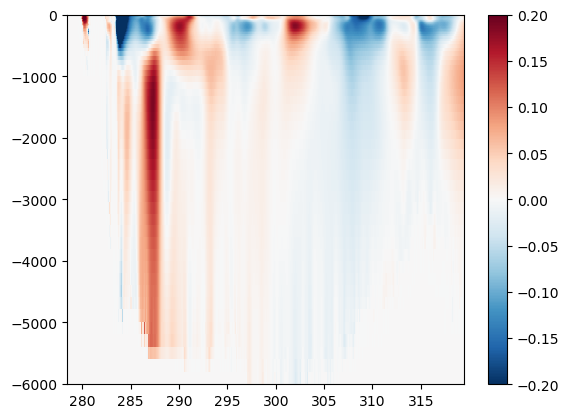

In [35]:
plt.pcolormesh(dsg.XG, rC50[:], uEs[-1,:,:], cmap='RdBu_r', vmin=-.2, vmax=.2)
plt.colorbar()

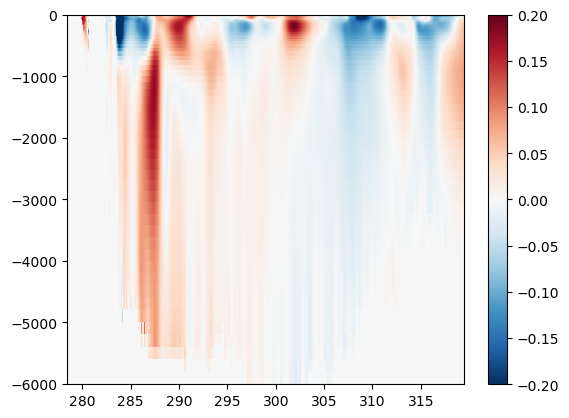

In [36]:
plt.pcolormesh(dsg.XG, rC50[:], uEs[0,:,:], cmap='RdBu_r', vmin=-.2, vmax=.2)
plt.colorbar()

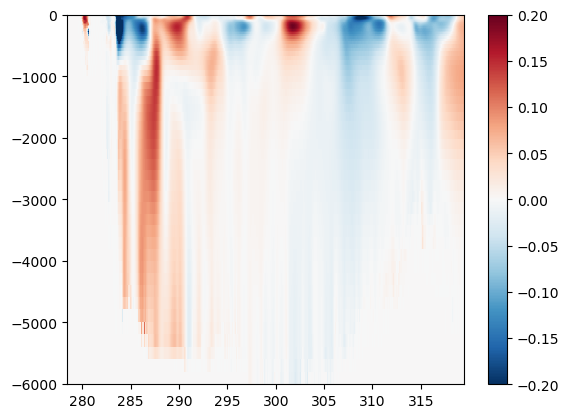

In [42]:
plt.pcolormesh(dsg.XG, rC50[:], uEs[1,:,:], cmap='RdBu_r', vmin=-.2, vmax=.2)
plt.colorbar()

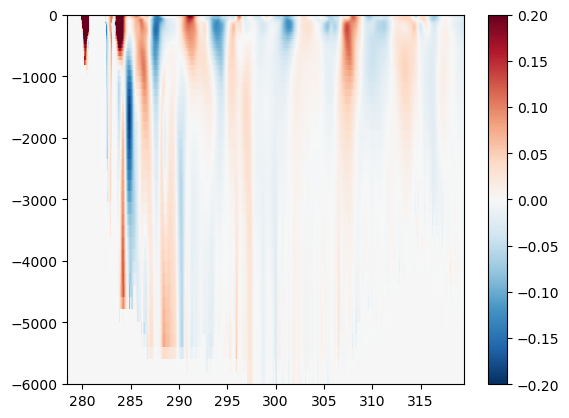

In [37]:
plt.pcolormesh(dsg.XC, rC50[:], vNs[-1,:,:], cmap='RdBu_r', vmin=-.2, vmax=.2)
plt.colorbar()

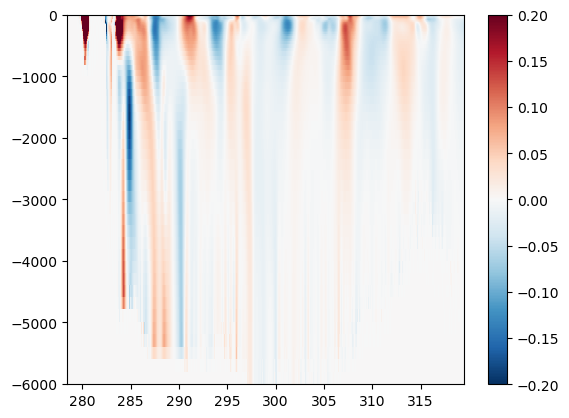

In [38]:
plt.pcolormesh(dsg.XC, rC50[:], vNs[0,:,:], cmap='RdBu_r', vmin=-.2, vmax=.2)
plt.colorbar()

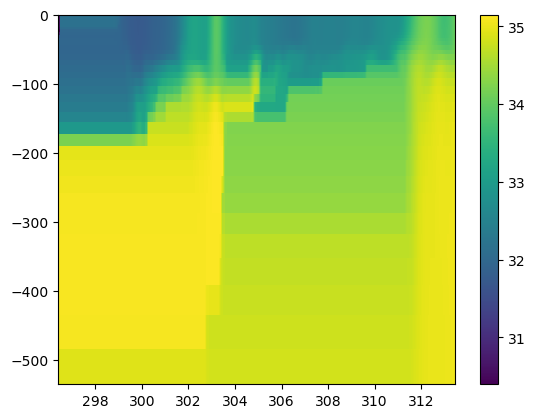

In [69]:
plt.pcolormesh(xx50[-1,900:-300], rC50[:40], sN[5,:40,900:-300])
plt.colorbar()

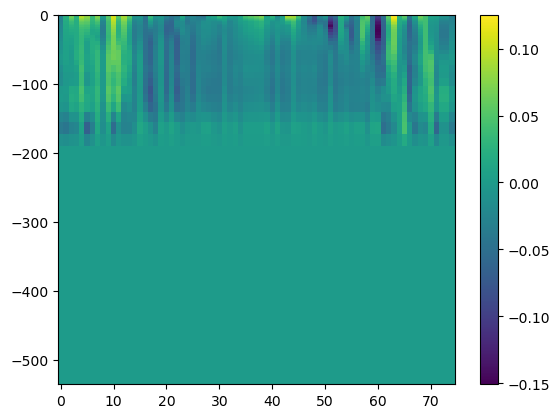

In [81]:
plt.pcolormesh(range(75), rC50[:40], uE[:,:40,1077].T)
plt.colorbar()

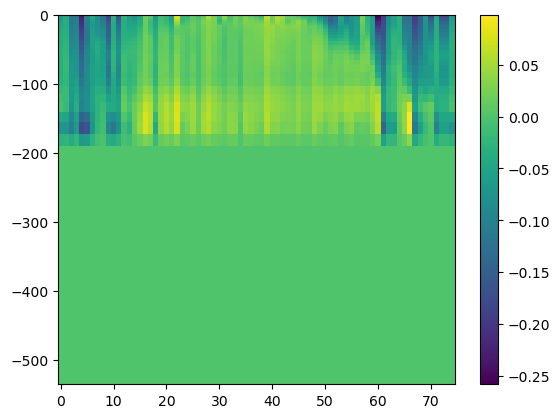

In [82]:
plt.pcolormesh(range(75), rC50[:40], vN[:,:40,1077].T)
plt.colorbar()

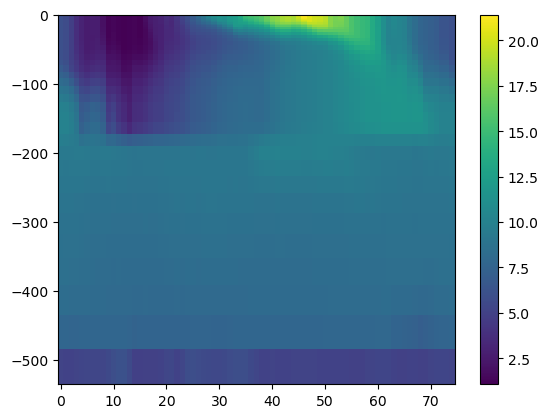

In [83]:
plt.pcolormesh(range(75), rC50[:40], tN[:,:40,1077].T)
plt.colorbar()

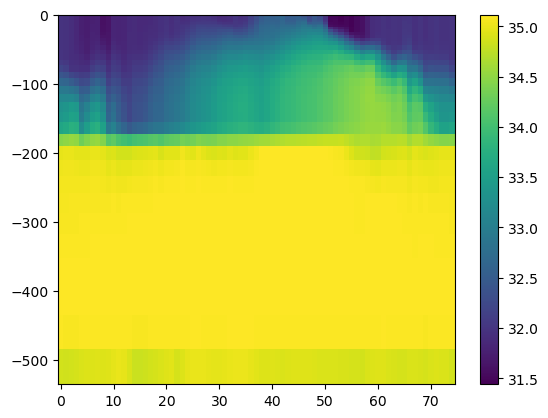

In [84]:
plt.pcolormesh(range(75), rC50[:40], sN[:,:40,1077].T)
plt.colorbar()

In [ ]:
plt.pcolormesh(tN[0])